In [1]:
# Note: Please follow to the About Fastai section in the README to update the fastai accordingly

In [1]:
# fastai library for training MLP on tabular data
from fastai.tabular.all import *

# for feature generation and plotting
from cryspnet.utils import *
# for accessing some pre-defined constant
from cryspnet.config import *

import pandas as pd
import numpy as np

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# this patch prevent the dsets field to be exported by the FillMissing transform
# would be removed in the future
@patch
def setups(self:FillMissing, dsets):
    missing = pd.isnull(dsets.conts).any()
    store_attr(but='dsets', na_dict={n:self.fill_strategy(dsets[n], self.fill_vals[n]) for n in missing[missing].keys()})
    self.fill_strategy = self.fill_strategy.__name__

In [5]:
# Modified the directory here to train your own model!!!!!

# read in the dataframe to train our model
df = pd.read_csv("../demo/demo_train.csv")

In [6]:
df.head()

,formula,Space Group,Bravais,a,b,c,alpha,beta,gamma
0,C4Hf1Ta2U1,225,cubic (F),4.615,4.615,4.615,90.0,90.0,90.0
1,Co1Sb1Ta1,216,cubic (F),5.883,5.883,5.883,90.0,90.0,90.0
2,Ge0.8Sb0.133Se0.133Te0.867,225,cubic (F),5.951,5.951,5.951,90.0,90.0,90.0
3,C1Ni1,225,cubic (F),4.077,4.077,4.077,90.0,90.0,90.0
4,Ir7Mg44,216,cubic (F),20.097,20.097,20.097,90.0,90.0,90.0


# Generate features with matminer

In [7]:
fgenerator = FeatureGenerator()

In [8]:
df_predictors = fgenerator.generate(df)

MultipleFeaturizer: 100%|██████████| 280/280 [00:00<00:00, 555.24it/s]


In [9]:
df_predictors.head()

,formula,Space Group,Bravais,a,b,c,alpha,beta,gamma,composition,...,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr,NComp
0,C4Hf1Ta2U1,225,cubic (F),4.615,4.615,4.615,90.0,90.0,90.0,"(C, Hf, Ta, U)",...,0,0.0,0,0,0,0,0,0,0,4
1,Co1Sb1Ta1,216,cubic (F),5.883,5.883,5.883,90.0,90.0,90.0,"(Co, Sb, Ta)",...,0,0.0,0,0,0,0,0,0,0,3
2,Ge0.8Sb0.133Se0.133Te0.867,225,cubic (F),5.951,5.951,5.951,90.0,90.0,90.0,"(Ge, Sb, Se, Te)",...,0,0.0,0,0,0,0,0,0,0,4
3,C1Ni1,225,cubic (F),4.077,4.077,4.077,90.0,90.0,90.0,"(C, Ni)",...,0,0.0,0,0,0,0,0,0,0,2
4,Ir7Mg44,216,cubic (F),20.097,20.097,20.097,90.0,90.0,90.0,"(Ir, Mg)",...,0,0.0,0,0,0,0,0,0,0,2


# Train models for lattice parameters

In [21]:
def initializer(df, dep_vars, cont_names=[], cat_names=[], classes=None, p=0.1, bs=32):
    """
        This is a wrapper function for creating a learner. It merges categoization and oversampling process into 
        one piece and assigns the correct metric and loss function to the fastai learner.
        The columns to be trained on are selected by the cont_names and cat_names. 
        
        Args:
            df: dataframe for training and validating the model
            dep_var: the dependance variable, must be a column of the df
            cont_names: column names of the continuous vairable (used for selecting the column to be trained on)
                see fastai documentation for more detail
            cat_names: column names of the category vairable (used for selecting the column to be trained on)
                see fastai documentation for more detail
            p: portion of train validation split. train : valid = 1-p : p
    """

    # split train and validation set and do oversampling if enabled
    val_idx= np.random.choice(df.index, int(len(df)*p), replace=False)
    splits = IndexSplitter(val_idx)(df.index)
    
    # y_range constrain the maximum and minium value of the predicted dependance variable
    y_range = ( group[dep_vars].min(axis=0).values, group[dep_vars].max(axis=0).values)
    y_range = ( torch.from_numpy(y_range[0]).to(device), torch.from_numpy(y_range[1]).to(device) )
                
    # create datasets
    trn_cols = list(cont_names) + list(cat_names) + dep_vars
    
    to = TabularPandas(df[trn_cols], procs=[Categorify, FillMissing, Normalize],
                   cat_names=cat_names,
                   cont_names=cont_names,
                   y_names=dep_vars,
                   splits=splits)
    
    # turn it into dataloader
    dls = to.dataloaders(bs=bs, device=device)
    
    # use the dataset to create the corresponding tabular learner
    # config allow us to tune the actual architecture
    config = tabular_config(ps=[0.0]+[0.1]*4, bn_cont=False, bn_final=True) # add drop out layer
    
    # create learner
    learn = tabular_learner(
        dls,
        layers=[256, 256, 256, 256], # set layer dimension
        config=config,
        y_range=y_range
    )
    
    learn.lattice_params = dep_vars
    
    return learn

In [11]:
# define where to save the learner -> the predict.py would load model from this directory
# you can modify these variable inside the config.py 
learner_folder = Path(LEARNER)
learner_folder.mkdir(exist_ok=True)

lattice_folder = learner_folder / LATTICE_PARAM_MODELS_FOLDER
lattice_folder.mkdir(exist_ok=True)

In [12]:
lattice_folder

Path('/home/aurora/cryspnet/cryspnet/learner/LatticeParam')

In [13]:
cont_names = list(df_predictors.columns[10:])
cat_names = []

In [14]:
groups = df_predictors.groupby("Bravais")

In [23]:
normalizations = {}
learns = {}

for Bravais, group in groups:
    dep_vars = PRED_COLS[Bravais]
    
    print(f"Training a model on {Bravais} subset")
    
    # dataframe preprocess
    
    group = group.reset_index(drop=True)
    group = group.copy()
    # remove large unit cell by this line
    # group = group.sort_values(by='v', ascending=False).iloc[int(len(group)*.1):]
    group = group.sample(frac=1)
    group.reset_index(drop=True, inplace=True)    
    
    # compute log of the dependance variable to enable log-RMSE error
    group[dep_vars] = np.log(group[dep_vars])

    # normalize the loged variable to scale
    mean = np.mean(group[dep_vars].values, axis=0)
    std = np.std(group[dep_vars].values, axis=0)

    normalizations[Bravais] = dict(mean=mean, std=std)
    group[dep_vars] = (group[dep_vars] - mean) / std
    
    # create learner using the preprocessed dataframe
    learn = initializer(
        group,
        dep_vars,
        cont_names=cont_names,
        cat_names=cat_names,
        p=0.1,
        bs=4 # we usually do 64 but the demo dataset is small so -u-
    )
    
    # find optimal learning rate
    suggestions = learn.lr_find(suggestions=True)
    # print(suggestions)
    
    lr_max=1e-2
    learn.fit_one_cycle(10, lr_max=lr_max)
    learn.fit_one_cycle(10, lr_max=lr_max)
    
    # save learner
    learn.export(lattice_folder/f"{Bravais}.pkl")    
    # save for later visualization
    learns[Bravais] = learn 
    
# store the mean and std for making prediction
import pickle
with (lattice_folder / LATTICE_NORM).open("wb") as f:
    pickle.dump(normalizations, f)

Training a model on cubic (F) subset


Training a model on cubic (I) subset


Training a model on cubic (P) subset


Training a model on hexagonal (P) subset


Training a model on monoclinic (C) subset


Training a model on monoclinic (P) subset


Training a model on orthorhombic (C) subset


Training a model on orthorhombic (F) subset


Training a model on orthorhombic (I) subset


Training a model on orthorhombic (P) subset


Training a model on rhombohedral (P) subset


Training a model on tetragonal (I) subset


Training a model on tetragonal (P) subset


Training a model on triclinic (P) subset


epoch,train_loss,valid_loss,time
0,0.802028,5.192107,00:00
1,0.792156,5.487454,00:00
2,0.774192,3.292282,00:00
3,0.832910,3.281692,00:00
4,0.867707,5.126259,00:00
5,0.871685,7.139389,00:00
6,0.875403,7.251834,00:00
7,0.878982,7.251834,00:00
8,0.865569,7.251834,00:00
9,0.857794,7.251834,00:00


# Visualize the prediction

In [24]:
def reverse_preprocess(tensor, norm):
    return np.exp( tensor * norm['std'] + norm['mean'] )

def plot_pred_target(bravais):
    learn = learns[bravais]
    preds, targets= learn.get_preds()

    targets = reverse_preprocess(targets, normalizations[bravais])
    preds = reverse_preprocess(preds, normalizations[bravais])

    for i in range(preds.shape[1]):

        plt.figure(figsize=(6,5))
        plt.scatter(targets[:,i], preds[:, i], alpha=0.2)

        axis_min = min( preds[:,i].min(), targets[:,i].min() )
        axis_max = max( preds[:,i].max(), targets[:,i].max() )

        plt.xlim(axis_min, axis_max)
        plt.ylim(axis_min, axis_max)
        plt.plot([axis_min, axis_max], [axis_min, axis_max], c="red")
        plt.title(PRED_COLS[Bravais][i], fontdict={"size":20})
        plt.show()

In [25]:
learns.keys()

dict_keys(['cubic (F)', 'cubic (I)', 'cubic (P)', 'hexagonal (P)', 'monoclinic (C)', 'monoclinic (P)', 'orthorhombic (C)', 'orthorhombic (F)', 'orthorhombic (I)', 'orthorhombic (P)', 'rhombohedral (P)', 'tetragonal (I)', 'tetragonal (P)', 'triclinic (P)'])

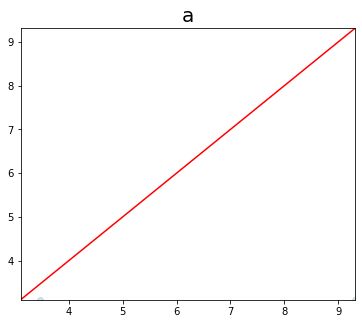

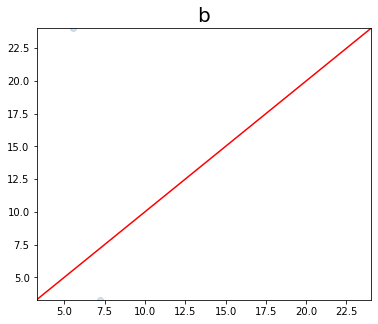

In [26]:
plot_pred_target("hexagonal (P)") # pick one from keys and visualize